In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV , RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

# Load the data
df = pd.read_csv('combined.csv')


In [2]:
# Strip any whitespace from column names
df.columns = df.columns.str.strip()

# Columns to remove, including IP addresses and ports which might not generalize well
columns_to_drop = ["flow ID", "source IP", "destination IP", "source port", "destination port", "date"]
df = df.drop(columns=columns_to_drop)

In [3]:
# Encoding categorical variables, including the 'Label' column
label_encoders = {}
categorical_columns = ['protocol', 'firstPacketDIR', 'mostCommonREQ_FUNC_CODE', 'mostCommonRESP_FUNC_CODE', 'Label']  # Include 'Label' as categorical
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

In [4]:
# Store the encoded labels separately and drop from dataframe
y = df['Label']
X = df.drop('Label', axis=1)


In [5]:
# Feature scaling
scaler = StandardScaler()
numerical_columns = X.select_dtypes(include=[np.number]).columns.tolist()  # Only scale numerical columns
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

In [6]:
# Handling imbalanced dataset with SMOTE
smote = SMOTE()
X_res, y_res = smote.fit_resample(X, y)


In [7]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)


In [8]:
# Model definitions with a hyperparameter grid suitable for RandomizedSearch
model_params = {
    "Decision Tree": {
        "model": DecisionTreeClassifier(),
        "params": {
            "max_depth": [10, 20, 30, None],  # Possible depths of the tree
            "min_samples_leaf": [1, 2, 4],    # Minimum number of samples required at each leaf node
            "criterion": ["gini", "entropy"]  # Function to measure the quality of a split
        }
    }
}

In [9]:
# Randomized search for hyperparameter tuning
n_iter_search = 20  # Number of parameter settings that are sampled
for model_name, mp in model_params.items():
    random_search = RandomizedSearchCV(mp['model'], param_distributions=mp['params'], 
                                       n_iter=n_iter_search, cv=5, scoring='accuracy',
                                       random_state=42, return_train_score=False)
    random_search.fit(X_train, y_train)
    y_pred = random_search.predict(X_test)
    
    print(f"Best parameters for {model_name}: {random_search.best_params_}")
    print(f"Classification report for {model_name}:\n{classification_report(y_test, y_pred)}")

Best parameters for Decision Tree: {'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'entropy'}
Classification report for Decision Tree:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81     32590
           1       1.00      1.00      1.00     32681
           2       0.75      0.74      0.74     32310
           3       0.74      0.75      0.75     32706
           4       0.96      0.97      0.96     32617
           5       1.00      1.00      1.00     32661
           6       1.00      1.00      1.00     32516
           7       0.97      0.96      0.96     32701
           8       0.81      0.81      0.81     32514

    accuracy                           0.89    293296
   macro avg       0.89      0.89      0.89    293296
weighted avg       0.89      0.89      0.89    293296



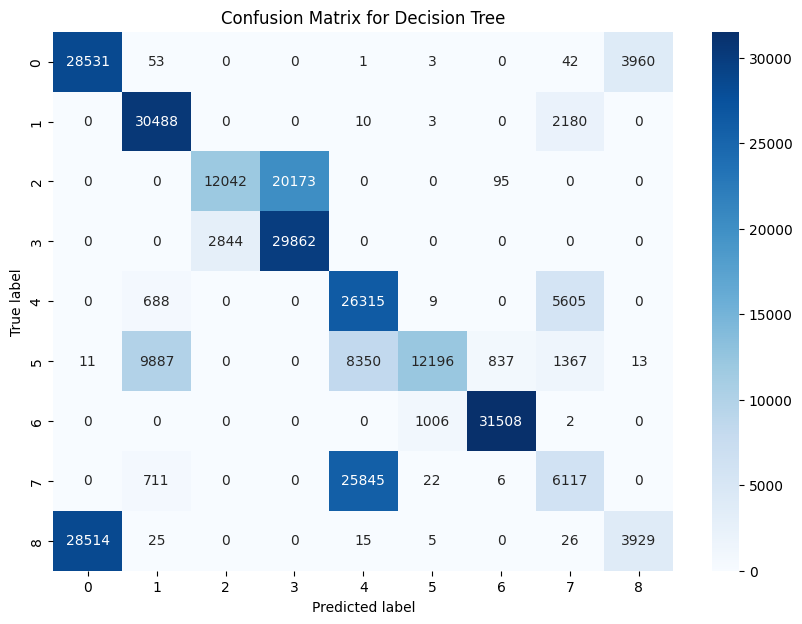

Text(0.5, 1.0, 'Receiver Operating Characteristic for Decision Tree')

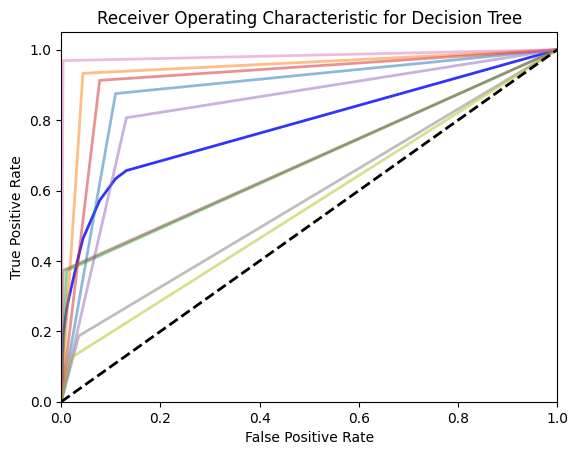

In [11]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix for Decision Tree')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Calculate ROC AUC for multi-class
y_test_bin = label_binarize(y_test, classes=[i for i in range(len(label_encoders['Label'].classes_))])
y_pred_bin = label_binarize(y_pred, classes=[i for i in range(len(label_encoders['Label'].classes_))])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_encoders['Label'].classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(label_encoders['Label'].classes_))]))

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(label_encoders['Label'].classes_)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= len(label_encoders['Label'].classes_)

# Plot all ROC curves
plt.figure()
plt.plot(all_fpr, mean_tpr, color='blue', label=f'Mean ROC (AUC = {auc(all_fpr, mean_tpr):.2f})', lw=2, alpha=0.8)
for i in range(len(label_encoders['Label'].classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, alpha=0.5, label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Decision Tree')